In [24]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/34 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N20.JPG
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N1.JPG
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/49 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N15.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/No18.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/31 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/no 6.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/3 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/no 5.jpeg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/no 1.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/26 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N26.JPG
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N5.jpg
/kaggle/input/brain-mri-images-for-b

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt

In [26]:
data = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

In [27]:
train_data = data.flow_from_directory(
    '/kaggle/input/brain-mri-images-for-brain-tumor-detection',
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

Found 406 images belonging to 3 classes.


In [28]:
val_data = data.flow_from_directory(
    '/kaggle/input/brain-mri-images-for-brain-tumor-detection',
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 100 images belonging to 3 classes.


In [29]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: 0.6666666666666666, 1: 1.7130801687763713, 2: 1.0913978494623655}


In [30]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False

In [31]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [32]:
model.compile(
    optimizer=Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [33]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    class_weight=class_weights,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 60s 4s/step - accuracy: 0.1998 - loss: 0.2154 - val_accuracy: 0.1900 - val_loss: 0.6429 - learning_rate: 1.0000e-04
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.1998 - loss: 0.0854 - val_accuracy: 0.1900 - val_loss: 0.7108 - learning_rate: 1.0000e-04
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.1909 - loss: -0.2000 - val_accuracy: 0.1900 - val_loss: 0.7546 - learning_rate: 1.0000e-04
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.1983 - loss: -0.2230 - val_accuracy: 0.1900 - val_loss: 0.7374 - learning_rate: 1.0000e-04
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.2016 - loss: -0.2554 - val_accuracy: 0.1900 - val_loss: 0.7510 - learning_rate: 2.0000e-05
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.2001 - loss: -0.2915 - val_accuracy: 0.1900 - val_loss: 0.7043 - learning_rate: 2.0000e-05
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.2009 - l

In [34]:
for layer in base_model.layers[-50:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(1e-5),  
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [35]:
history_fine = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    class_weight=class_weights,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)]
)


Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 96s 5s/step - accuracy: 0.2098 - loss: -0.0150 - val_accuracy: 0.1900 - val_loss: 0.4313 - learning_rate: 1.0000e-05
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 65s 5s/step - accuracy: 0.1872 - loss: -0.0559 - val_accuracy: 0.1900 - val_loss: 0.4784 - learning_rate: 1.0000e-05
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 64s 5s/step - accuracy: 0.1979 - loss: -0.2574 - val_accuracy: 0.1900 - val_loss: 0.2561 - learning_rate: 1.0000e-05
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 66s 5s/step - accuracy: 0.2103 - loss: 0.0164 - val_accuracy: 0.1900 - val_loss: 0.3982 - learning_rate: 1.0000e-05
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 66s 5s/step - accuracy: 0.2144 - loss: -0.1332 - val_accuracy: 0.1900 - val_loss: 0.3061 - learning_rate: 1.0000e-05
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 64s 5s/step - accuracy: 0.1875 - loss: -0.5134 - val_accuracy: 0.1900 - val_loss: 0.2582 - learning_rate: 1.0000e-05
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - accuracy: 0.2090 - 

In [36]:
# def plot_history(hist, title):
#     plt.plot(hist.history['accuracy'], label='train acc')
#     plt.plot(hist.history['val_accuracy'], label='val acc')
#     plt.title(title + ' - Accuracy')
#     plt.legend()
#     plt.show()

#     plt.plot(hist.history['loss'], label='train loss')
#     plt.plot(hist.history['val_loss'], label='val loss')
#     plt.title(title + ' - Loss')
#     plt.legend()
#     plt.show()

In [39]:
model.save("brain_tumor_model.h5")

In [40]:
from tensorflow.keras.models import load_model
model = load_model("brain_tumor_model.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
 Tumor Detected


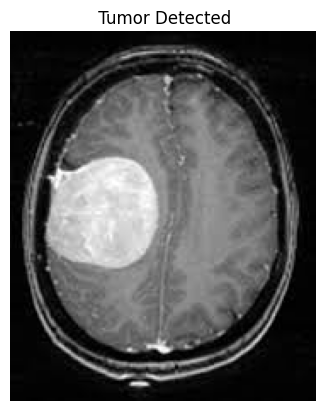

In [43]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input


model = load_model("brain_tumor_model.h5")

img_path = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset' + "/yes/Y1.jpg"   

img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

prediction = model.predict(img_array)

plt.imshow(image.load_img(img_path))
plt.axis("off")
if prediction[0][0] > 0.5:
    plt.title(" Tumor Detected")
    print(" Tumor Detected")
else:
    plt.title(" No Tumor Detected")
    print(" No Tumor Detected")
plt.show()
